In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl

In [2]:
df  = pd.read_csv("car_details_from_car_dekho.csv.xls")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
enc = LabelEncoder()
enc.fit(df['seller_type'])
df['seller_type'] = enc.transform(df['seller_type'])
enc.fit(df['owner'])
df['owner'] = enc.transform(df['owner'])
enc.fit(df['fuel'])
df['fuel'] = enc.transform(df['fuel'])
enc.fit(df['transmission'])
df['transmission'] = enc.transform(df['transmission'])
cdf = df[['year', 'selling_price', 'km_driven', 'fuel', 'transmission', 'owner','seller_type']]
cdf.head(9)

,year,selling_price,km_driven,fuel,transmission,owner,seller_type
0,2007,60000,70000,4,1,0,1
1,2007,135000,50000,4,1,0,1
2,2012,600000,100000,1,1,0,1
3,2017,250000,46000,4,1,0,1
4,2014,450000,141000,1,1,2,1
5,2007,140000,125000,4,1,0,1
6,2016,550000,25000,4,1,0,1
7,2014,240000,60000,4,1,2,1
8,2015,850000,25000,4,1,0,1


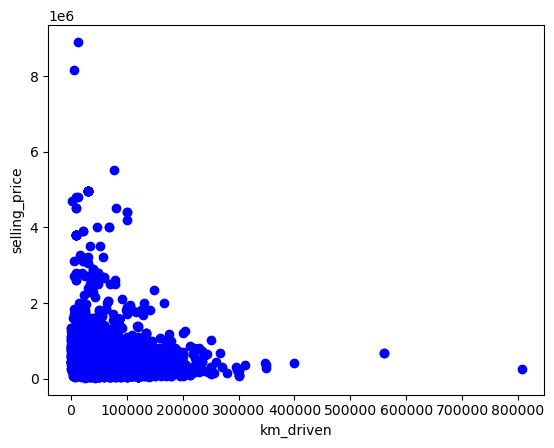

In [4]:
plt.scatter(cdf.km_driven, cdf.selling_price,  color='blue')
plt.xlabel("km_driven")
plt.ylabel("selling_price")
# plt.xlim(0,400000)
# plt.ylim(0,500000)
plt.show()

In [8]:
from sklearn import linear_model
from sklearn.metrics import r2_score

X = np.asanyarray(cdf[['year','km_driven', 'fuel', 'transmission', 'owner', 'seller_type']])
Y = np.asanyarray(cdf[['selling_price']])

r2 = -1

while r2 < 0.53:
    random_st = np.random.randint(0, 100)
    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.15, random_state=random_st)
    regr = linear_model.LinearRegression()

    regr.fit (train_x, train_y)

    test_y_ = regr.predict(test_x)
    r2 = r2_score(test_y,test_y_)
    print("R2-score: %.2f" % r2 )
    


print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)


print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2 )

R2-score: 0.35
R2-score: 0.46
R2-score: 0.44
R2-score: 0.49
R2-score: 0.36
R2-score: 0.47
R2-score: 0.39
R2-score: 0.46
R2-score: 0.39
R2-score: 0.42
R2-score: 0.47
R2-score: 0.49
R2-score: 0.41
R2-score: 0.41
R2-score: 0.38
R2-score: 0.41
R2-score: 0.39
R2-score: 0.49
R2-score: 0.35
R2-score: 0.35
R2-score: 0.42
R2-score: 0.44
R2-score: 0.46
R2-score: 0.47
R2-score: 0.45
R2-score: 0.38
R2-score: 0.48
R2-score: 0.44
R2-score: 0.48
R2-score: 0.39
R2-score: 0.50
R2-score: 0.45
R2-score: 0.44
R2-score: 0.49
R2-score: 0.39
R2-score: 0.41
R2-score: 0.41
R2-score: 0.44
R2-score: 0.40
R2-score: 0.48
R2-score: 0.41
R2-score: 0.46
R2-score: 0.41
R2-score: 0.44
R2-score: 0.48
R2-score: 0.53
R2-score: 0.35
R2-score: 0.53
R2-score: 0.42
R2-score: 0.39
R2-score: 0.46
R2-score: 0.41
R2-score: 0.44
R2-score: 0.52
R2-score: 0.40
R2-score: 0.51
R2-score: 0.51
R2-score: 0.49
R2-score: 0.42
R2-score: 0.44
R2-score: 0.38
R2-score: 0.40
R2-score: 0.45
R2-score: 0.51
R2-score: 0.38
R2-score: 0.51
R2-score: 